In [3]:
# general package imports
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, log_loss, roc_auc_score, auc, roc_curve, accuracy_score, confusion_matrix, cohen_kappa_score

import warnings
warnings.simplefilter('ignore')

In [4]:
# image imports
from matplotlib.image import imread

In [5]:
# cnn imports
import cv2
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,Activation,MaxPooling2D,Dense,Flatten,Dropout

In [6]:
sns.set(font_scale=1.5)
sns.set_style('white')

In [7]:
# control reproducibility with random seeds
seed_value = 1

np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

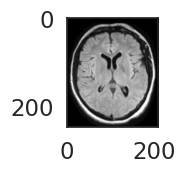

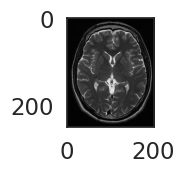

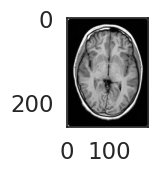

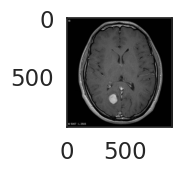

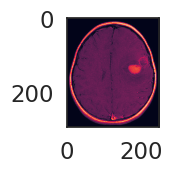

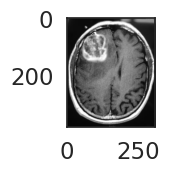

In [8]:
# define location of dataset
folder_no = 'brain_tumor_dataset/no'
folder_yes = 'brain_tumor_dataset/yes'

i = 0

for filepath, gt in zip([folder_no,folder_yes],[0,1]):

    # plot first few images
    for f in os.listdir(filepath)[0:3]:

        i = i+1

        # define subplot
        plt.subplot(330 + 1 + i)

        # define filename
        filename = filepath + '/' + f

        # load image pixels
        image = imread(filename)

        # plot raw pixel data
        plt.imshow(image)

        # show the figure
        plt.show()

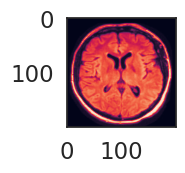

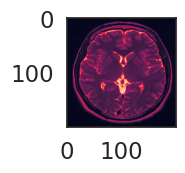

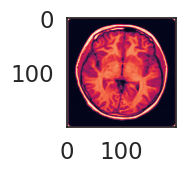

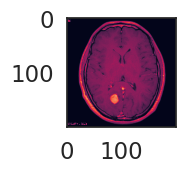

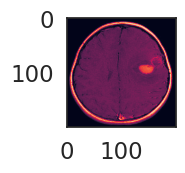

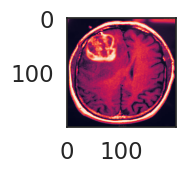

In [10]:
# define location of dataset
folder_no = 'brain_tumor_dataset/no'
folder_yes = 'brain_tumor_dataset/yes'

i = 0

for filepath, gt in zip([folder_no,folder_yes],[0,1]):

    # plot first few images
    for f in os.listdir(filepath)[0:3]:

        i = i+1

        # define subplot
        plt.subplot(330 + 1 + i)

        # define filename
        filename = filepath + '/' + f

        # load image pixels
        image = imread(filename)

        # resize into standard size for all images
        resized_image = cv2.resize(image,dsize=(200,200))

        # in case of grayscale images
        if len(np.shape(resized_image)) > 2:

            # convert the image from COLOR_BGR2GRAY
            resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # plot raw pixel data
        plt.imshow(resized_image)

        # show the figure
        plt.show()

In [11]:
# Read images into array
filepath = 'brain_tumor_dataset/'

images, labels, filenames = [], [], []

for gt in ['yes','no']:

    filepath_gt = filepath + gt

    for f in os.listdir(filepath_gt):

        filename = filepath_gt + '/' + f

        if '._' not in filename: # metadata files created by macos

            # load image
            photo = tf.keras.utils.load_img(path=filename,target_size=(200, 200))

            # load image pixels
            image = imread(filename)
            resized_image = cv2.resize(image,dsize=(200,200))

            # in case of grayscale images
            if len(np.shape(resized_image)) > 2:
                # convert the image from COLOR_BGR2GRAY
                resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

            # store to array
            images.append(resized_image)
            filenames.append(filename)

            if gt=='yes':
                label = 1
                labels.append(label)
            elif gt=='no':
                label = 0
                labels.append(label)

In [12]:
# Split into train/test sets (stratify by GT)
gtFr = pd.DataFrame(labels).rename(columns={0:'gt'}).reset_index(drop=False).rename(columns={'index':'pID'})
gtFr['filename'] = filenames

# split into training and testing sets, stratifying by gt for equal representation
trainFr, testFr = train_test_split(gtFr, test_size=0.2, stratify=gtFr['gt'])

# store training/testing indices
trainFr['set'] = 'train'
testFr['set'] = 'test'

gtFr2 = pd.concat([trainFr,testFr],axis=0)
gtFr2.set_index(['filename']).to_csv('base_model_train_test.csv')

In [13]:
# Load and reformat training data
files_train = []
X_train = []
y_train = []

for idx, row in trainFr.iterrows():
    # load image pixels
    image = imread(row['filename'])

    # resize image to standard 200x200
    resized_image = cv2.resize(image,dsize=(200,200))

    # in case of grayscale images
    if len(np.shape(resized_image)) > 2:
        # convert the image from COLOR_BGR2GRAY
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # store to array
    X_train.append(resized_image)
    y_train.append(row['gt'])
    files_train.append(row['filename'])

# reshape data to fit model
X_train = np.array(X_train).reshape(len(trainFr),200,200,1)
y_train = np.array(y_train)

In [14]:
# Load and reformat testing data
files_test = []
X_test = []
y_test = []

for idx, row in testFr.iterrows():
    # load image pixels
    image = imread(row['filename'])

    # resize image to standard 200x200
    resized_image = cv2.resize(image,dsize=(200,200))

    # in case of grayscale images
    if len(np.shape(resized_image)) > 2:
        # convert the image from COLOR_BGR2GRAY
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # store to array
    X_test.append(resized_image)
    y_test.append(row['gt'])
    files_test.append(row['filename'])

# reshape data to fit model
X_test = np.array(X_test).reshape(len(testFr),200,200,1)
y_test = np.array(y_test)

In [15]:
# Build, compile, and train CNN
# create model
model = Sequential()

# add convolutional layer
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(200,200,1))) # specify shape of images

# add max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer
model.add(Conv2D(32, kernel_size=3, activation='relu'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten output (connect convolutional layers and dense layers)
model.add(Flatten())

# add a dense layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu'))

# add dense layer
model.add(Dense(1, activation='sigmoid'))

# compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/50
7/7 [==============================] - 1s 81ms/step - loss: 2.9874e-05 - accuracy: 1.0000 - val_loss: 2.0274 - val_accuracy: 0.8235
Epoch 2/50
7/7 [==============================] - 0s 57ms/step - loss: 2.8300e-05 - accuracy: 1.0000 - val_loss: 2.0328 - val_accuracy: 0.8235
Epoch 3/50
7/7 [==============================] - 0s 56ms/step - loss: 2.6593e-05 - accuracy: 1.0000 - val_loss: 2.0363 - val_accuracy: 0.8235
Epoch 4/50
7/7 [==============================] - 0s 56ms/step - loss: 2.5291e-05 - accuracy: 1.0000 - val_loss: 2.0404 - val_accuracy: 0.8235
Epoch 5/50
7/7 [==============================] - 0s 58ms/step - loss: 2.4229e-05 - accuracy: 1.0000 - val_loss: 2.0455 - val_accuracy: 0.8235
Epoch 6/50
7/7 [==============================] - 0s 42ms/step - loss: 2.3070e-05 - accuracy: 1.0000 - val_loss: 2.0493 - val_accuracy: 0.8235
Epoch 7/50
7/7 [==============================] - 0s 42ms/step - loss: 2.2042e-05 - accuracy: 1.0000 - val_loss: 2.0535 - val_accuracy: 0.8235

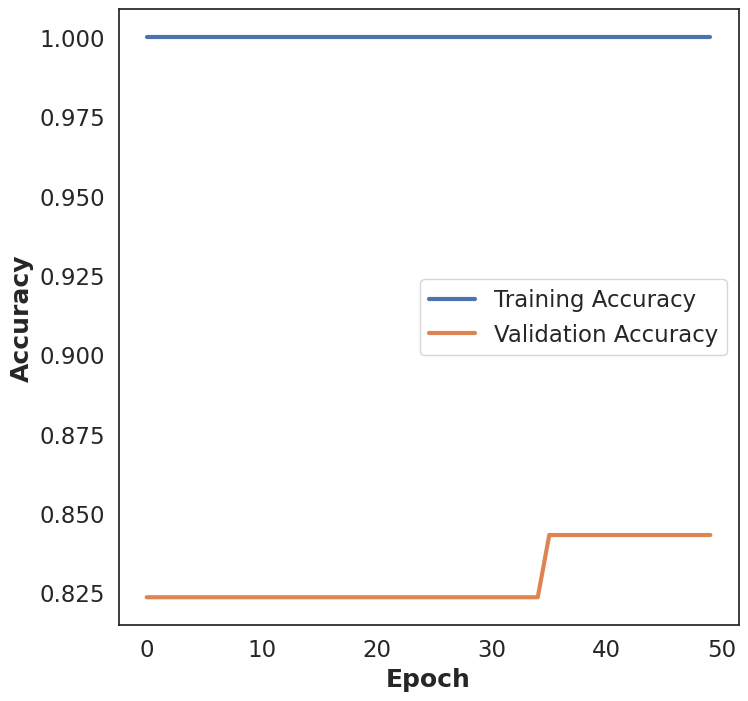

In [18]:
# Plot the training and validation accuracy against number of epochs
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(history.history['accuracy'], label='Training Accuracy',lw=3)
ax.plot(history.history['val_accuracy'], label='Validation Accuracy',lw=3)
ax.set_xlabel('Epoch',weight='bold')
ax.set_ylabel('Accuracy',weight='bold')
ax.legend()

plt.savefig('accuracy_over_epochs.png')
plt.show()

In [19]:
# make predictions
predictions = model.predict(X_test)

# store as probabilities
probabilities = [p[0] for p in predictions]
testFr['pred'] = probabilities

2/2 [==============================] - 0s 11ms/step


In [21]:
testFr.set_index(['pID']).to_csv('base_model_predictions.csv')

In [24]:
# Evaluate results
dataPos = testFr[testFr['gt']==1]['pred'].values
dataNeg = testFr[testFr['gt']==0]['pred'].values
dataAll = np.concatenate((dataPos, dataNeg))
lblArr = np.zeros(len(dataAll), dtype=bool)
lblArr[0:len(dataPos)] = True

fpr, tpr, thresholds = roc_curve(lblArr, dataAll, pos_label=True)
roc_auc = auc(fpr, tpr)

# invert comparison if (ROC<0.5) required
if roc_auc<0.5:
    lblArr = ~lblArr
    fpr, tpr, thresholds = roc_curve(lblArr, dataAll, pos_label=True)
    roc_auc = auc(fpr, tpr)
    print('inverting labels')

print('ROC AUC: {:0.2f}'.format(roc_auc))

# calculate best cut-off based on distance to top corner of ROC curve
distArr = np.sqrt(np.power(fpr, 2) + np.power((1 - tpr), 2))
cutoffIdx = np.argsort(distArr)[0]
cutoffTh = thresholds[cutoffIdx]

print('Cutoff threshold that maximizes sens/spec: {:0.2f}'.format(cutoffTh))

lblOut = dataAll >= cutoffTh

acc = accuracy_score(lblArr, lblOut)
print('Accuracy: {:0.2f}'.format(acc))

sens = tpr[cutoffIdx]
print('Sensitivity: {:0.2f}'.format(sens))

spec = 1 - fpr[cutoffIdx]
print('Specificity: {:0.2f}'.format(spec))

kappa = cohen_kappa_score(lblOut, lblArr)
print('Cohen kappa score: {:0.2f}'.format(kappa))

ROC AUC: 0.90
Cutoff threshold that maximizes sens/spec: 0.99
Accuracy: 0.86
Sensitivity: 0.81
Specificity: 0.95
Cohen kappa score: 0.72


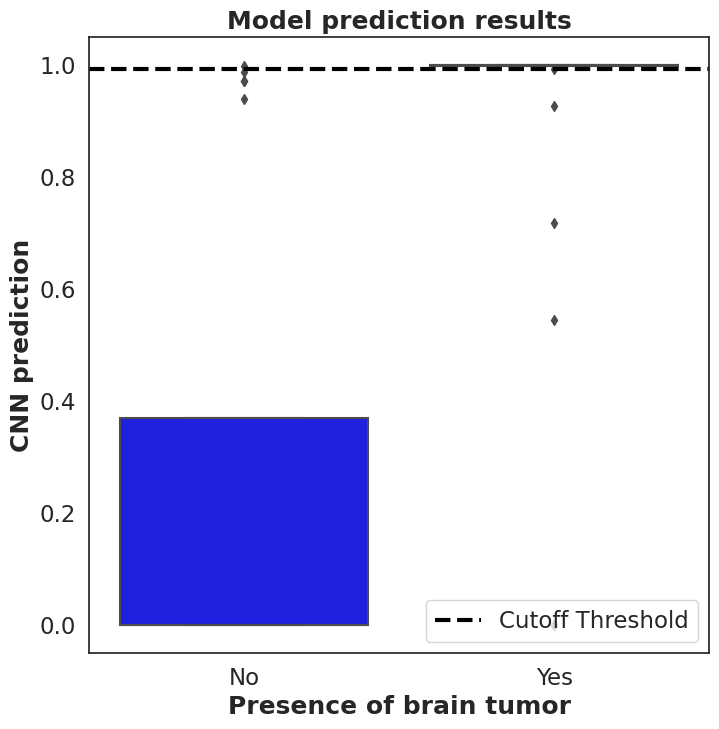

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

sns.boxplot(y=testFr['pred'],x=testFr['gt'],palette=['blue','red'])
ax.set_xticklabels(['No','Yes'])
ax.set_xlabel('Presence of brain tumor',weight='bold')
ax.set_ylabel('CNN prediction',weight='bold')
ax.axhline(cutoffTh,lw=3,linestyle='--',color='black',label='Cutoff Threshold')
ax.set_title('Model prediction results',weight='bold')
ax.legend(loc=4)

plt.savefig('cnn_prediction_boxplot_by_gt.png')
plt.show()